In [1]:
!python3 -m pip install -U yt-dlp > /dev/null

In [2]:
!yt-dlp -S "res:720" https://www.youtube.com/watch?v=PNCJQkvALVc -o traffic

[youtube] PNCJQkvALVc: Downloading webpage
[youtube] PNCJQkvALVc: Downloading android player API JSON
[info] PNCJQkvALVc: Downloading 1 format(s): 247+251
[download] traffic.webm has already been downloaded


In [3]:
import cv2
import time
import torch
import numpy as np
from IPython.display import clear_output 

In [4]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.train(False)
clear_output()

In [5]:
def benchmark(model, filename, device="cpu", duration=1):
    cap = cv2.VideoCapture(filename)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frames = [cap.read()[1] for _ in range(fps * duration)]
    start = time.monotonic()
    model.to(device)
    with torch.no_grad():
        output = model(frames)
    elapsed = time.monotonic() - start
    print(f"FPS: {len(frames) / elapsed}")

In [6]:
!cat /proc/cpuinfo | grep "model name"

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [7]:
%%timeit
benchmark(model, "traffic.webm", device="cpu")

FPS: 2.9593918326578907
FPS: 4.823556924266503
FPS: 4.743118933772205
FPS: 4.702692451809428
FPS: 4.630025593705497
FPS: 4.747249658598117
FPS: 4.775126214135119
FPS: 4.711679824636329
5.38 s ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
!nvidia-smi

Sun Oct  9 13:32:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |    876MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
%%timeit
benchmark(model, "traffic.webm", device="cuda:0")

FPS: 24.5296366137268
FPS: 133.65872210650033
FPS: 145.73277528908798
FPS: 139.58570538326998
FPS: 146.90823567463676
FPS: 147.89768003101335
FPS: 146.54499282139577
FPS: 143.35486850329642
277 ms ± 7.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
from PIL import Image, ImageDraw

In [11]:
cap = cv2.VideoCapture("traffic.webm")
_, frame = cap.read()
output = model(frame)

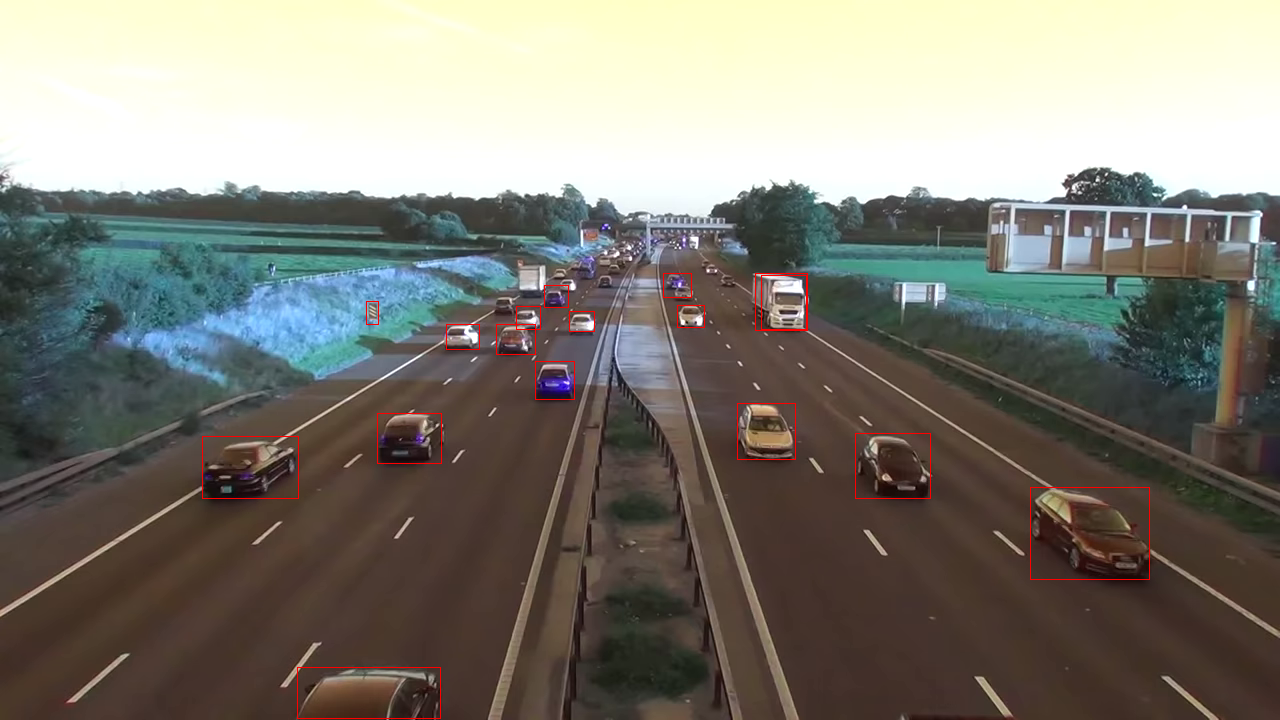

In [12]:
image = Image.fromarray(output.ims[0])
draw = ImageDraw.Draw(image)
w, h = image.size
for x1, y1, x2, y2, _, _ in output.xyxyn[0]:
    draw.rectangle(((x1 * w, y1 * h), (x2 * w, y2 * h)), outline='Red')
image

In [13]:
from google.colab.patches import cv2_imshow

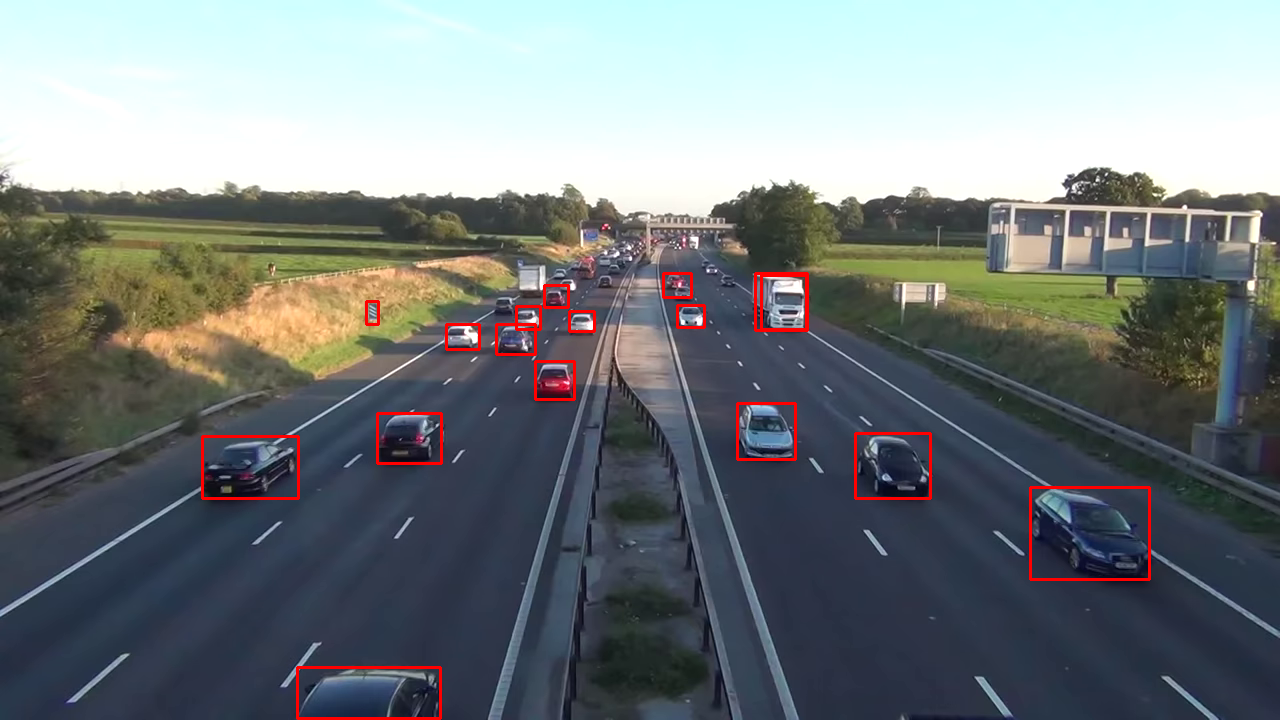

In [14]:
im = output.ims[0]
h, w, _ = im.shape
for x1, y1, x2, y2, _, _ in output.xyxyn[0]:
    cv2.rectangle(
        im, (int(x1 * w), int(y1 * h)), (int(x2 * w), int(y2 * h)), (0,0,255), 2
    ) 
cv2_imshow(im)

In [15]:
import os
import sys
import threading
from queue import Queue, Empty, Full
import multiprocessing as mp
from threading import Thread, Event
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [16]:
# Создание потока для чтения на основе входящего потока
def create_output_stream(cap, filename):
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(
        filename, cv2.VideoWriter_fourcc(*"MP4V"), 
        fps, (frame_width, frame_height)
    )
    return out

In [17]:
# Все входящие видеопотоки и названия видео, в которые будут сохранены  после обработки
sources = [
    ("traffic.webm", "test.mp4"),
    #("rtsp://wowzaec2demo.streamlock.net/vod/mp4:BigBuckBunny_115k.mp4", "test2.mp4")
]

In [18]:
# Получаем кадр из потока и отправляем его в очередь обработки
def producer(queue: Queue, source, filename, event):
    cap = cv2.VideoCapture(source)
    out = create_output_stream(cap, filename)
    while cap.isOpened() and not event.is_set():
        result, frame = cap.read()
        try:
            queue.put((frame, out), timeout=0.1)
        except Full:
            break
        cv2.waitKey(1)
    out.release()
    print("producer done")
# Тут должна быть обработка кадра нейронкой и распознавание номера, но пока
# просто идет добавление кадра в очередь для записи
def consumer(queue: Queue, output: Queue, event):
    while not event.is_set():
        try:
            frame, out = queue.get(timeout=0.1)
        except Empty:
            break
        #with torch.no_grad():
        #    outputs = model(frame)
        #img = outputs.ims[0]
        #h, w, _ = img.shape
        #for x1, y1, x2, y2, _, _ in output.xyxyn[0]:
        #    cv2.rectangle(
        #        img, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (0,0,255), 2
        #    ) 
        #output.put((img, out))
        try:
            output.put((frame, out))
        except Full:
            break
        queue.task_done()
        cv2.waitKey(1)
    print("consumer done")     
# Записываем кадры в файлы
def writer(output: Queue, event):
    while True:
        try:
            frame, out = output.get(timeout=0.1)
        except Empty:
            break
        if event.is_set():
            output.task_done()
            break
        out.write(frame)
        output.task_done()
        cv2.waitKey(1)
    print("writer done")

In [19]:
# Setup some stuff
queue = Queue(maxsize=60)
output = Queue(maxsize=60)
event = Event()
executor = ThreadPoolExecutor()
# Start threads
for source, filename in sources:
    executor.submit(producer, queue, source, filename, event)
executor.submit(consumer, queue, output, event)
executor.submit(writer, output, event)
# Running
try: 
    executor.shutdown()
except:
    event.set()
    executor.shutdown()

writer doneconsumer done

producer done
